# Deep Neural Network Model - Hiperparameters Tuning

Input: testing different number of months in input using single PCA

Output: optimal max-shape portfolio with tight restrictions for the next period

## Data Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.regularizers import L2
from keras.optimizers import Adam

from sklearn.model_selection import StratifiedKFold
import keras_tuner

from helper_functions import train_and_evaluate_model, calculate_returns_for_model, calculate_metrics, daily_to_annual_returns

In [2]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [3]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

In [4]:
days_to_recalculate = data_provider.get_days_to_recalculate()

# Start after 1 year to have enough historic data for first calculated period
days_to_recalculate = days_to_recalculate.iloc[12:]
days_to_recalculate = pd.DatetimeIndex(days_to_recalculate)
days_to_recalculate

DatetimeIndex(['2000-01-04', '2000-02-04', '2000-03-06', '2000-04-04',
               '2000-05-04', '2000-06-06', '2000-07-05', '2000-08-04',
               '2000-09-06', '2000-10-04',
               ...
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023-10-05',
               '2023-11-03', '2023-12-05'],
              dtype='datetime64[ns]', name='Days to rebalance', length=288, freq=None)

Preparing outputs common for all models

In [5]:
os.chdir(os.path.expanduser('../optimization'))

from PortfolioOptimizer import PortfolioOptimizer

In [6]:
y = []
for i in range(0,len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    try:
        optimizer = PortfolioOptimizer()
        w, constraints = optimizer.get_tight_constraints(acwi_weights_year)
        optimal_portfolio = optimizer.get_optimal_portfolio(
            data_period, w, constraints)
    except:        
        summed_weight = acwi_weights_year.sum(axis=1)
        scaled_acwi_weights = acwi_weights_year.iloc[0] / summed_weight.values[0]
        optimal_portfolio = scaled_acwi_weights.round(3)
        print('Cannot get optimal portfolio for', days_to_recalculate[i])

    y.append(optimal_portfolio.values)

y = np.array(y)
y.shape

Cannot get optimal portfolio for 2022-05-06 00:00:00
Cannot get optimal portfolio for 2022-08-03 00:00:00


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cannot get optimal portfolio for 2023-03-03 00:00:00
Cannot get optimal portfolio for 2023-05-04 00:00:00


(288, 27)

In [7]:
val_split = int(0.7 * y.shape[0])
test_split = int(0.8 * y.shape[0])

# Train
dates_for_training = days_to_recalculate[:val_split]
y_train = y[:val_split]

# Validation
dates_for_validation = days_to_recalculate[val_split:test_split]
y_val = y[val_split:test_split]

# Test
dates_for_test = days_to_recalculate[test_split:]
y_test = y[test_split:]

In [8]:
os.chdir(os.path.expanduser('../data'))

In [9]:
df_prices_val = df_countries[dates_for_validation[0]:]
df_returns_val = np.log(df_prices_val).diff().fillna(0)

## Cross validation to calculate optimal number of months

In [67]:
max_sharpe = 0
best_month_no = 0

for no_months in range(3, 10):
    print(f'DNN Model for {no_months} months')
    x = []
    for date in days_to_recalculate:
        indicators = data_provider.calculate_principal_component_from_indicators(
            date, periods=no_months, indicators=all_indicators)
        x.append(indicators.values)

    x_pca = np.array(x)
    x_train = x_pca[:val_split]
    x_val = x_pca[val_split:test_split]
    x_test = x_pca[test_split:]

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(x_train, y_train)

    sum_sharpe = 0
    for _, (train_index, val_index) in enumerate(skf.split(x_train, np.zeros(y_train.shape[0]))):
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]
        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        model = Sequential((
            Flatten(input_shape=x_train.shape[1:]),
            Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
            Dense(y_train.shape[1], activation='softmax')
        ))
        model.compile(optimizer=Adam(learning_rate=1e-3),
                      loss='mean_squared_error')
        _ = model.fit(x_train_fold, y_train_fold,
                      validation_data=(x_val_fold, y_val_fold),
                      epochs=200, verbose=False)

        total_ret_val, _ = calculate_returns_for_model(
            model, x_val, dates_for_validation,
            df_returns_val, df_countries.columns)

        annual_returns = daily_to_annual_returns(total_ret_val)
        annual_volatility = total_ret_val.std()*np.sqrt(252)
        annual_sharpe_val = annual_returns/annual_volatility
        sum_sharpe += annual_sharpe_val
        print('Sharpe fold', annual_sharpe_val)

    mean_sharpe_val = sum_sharpe/5
    print('Mean Sharpe', mean_sharpe_val)
    if mean_sharpe_val > max_sharpe:
        max_sharpe = mean_sharpe_val
        best_month_no = no_months

print('Best number of months', best_month_no, 'with mean Sharpe ratio', max_sharpe)

DNN Model for 3 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.3965228676316803
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sharpe fold 0.4054607585703938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Sharpe fold 0.3865306595095709
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sharpe fold 0.38627383421159095
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sharpe fold 0.3950762868767917
Mean Sharpe 0.3939728813600055
DNN Model for 4 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.40014008527486405
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sharpe fold 0.4066517343344325
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.39725339186629594
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sharpe fold 0.388148947866222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sharpe fold 0.38081492722149857
Mean Sharpe 0.39460181731266264
DNN Model for 5 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sharpe fold 0.40199247455640136
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Sharpe fold 0.4071286358836478
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Sharpe fold 0.4037728005023462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sharpe fold 0.39842311456985446
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Sharpe fold 0.3951333714604082
Mean Sharpe 0.4012900793945316
DNN Model for 6 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.398255062785248
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Sharpe fold 0.4007245968936193
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sharpe fold 0.42918749400579465
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Sharpe fold 0.39843535615357273
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.40216083563331384
Mean Sharpe 0.4057526690943097
DNN Model for 7 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Sharpe fold 0.4117626352656794
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sharpe fold 0.3982713353163803
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sharpe fold 0.41769454809267265
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Sharpe fold 0.36651328328960175
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sharpe fold 0.4215299971082355
Mean Sharpe 0.403154359814514
DNN Model for 8 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.411119880988187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Sharpe fold 0.39488978334066266
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Sharpe fold 0.37641666797785484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sharpe fold 0.39682611821971775
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sharpe fold 0.3829733748276284
Mean Sharpe 0.3924451650708101
DNN Model for 9 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sharpe fold 0.40384483490073886
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.41637978338428977
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Sharpe fold 0.41414153902606676
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Sharpe fold 0.40063589487014845
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.4071387376613216
Mean Sharpe 0.40842815796851306
Best number of months 9 with mean Sharpe ratio 0.40842815796851306


In [70]:
best_month_no = 6

In [71]:
x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=best_month_no, indicators=all_indicators)
    x.append(indicators.values)

x_pca = np.array(x)
x_train = x_pca[:val_split]
x_val = x_pca[val_split:test_split]
x_test = x_pca[test_split:]

## Hiperparameters Tuning

In [72]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(hp.Choice('units', [64, 128, 256]),
              activation='relu', 
              kernel_regularizer=L2(hp.Choice('reg', [0.0, 0.1]))))
    
    if hp.Boolean("second_layer"):
        model.add(Dense(hp.Choice('units2', [64, 128, 256]),
              activation='relu', 
              kernel_regularizer=L2(hp.Choice('reg2', [0.0, 0.1])))),
    
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='mse')
    return model

In [73]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=100,
    directory='tuning',
    project_name='model_dnn')

Reloading Tuner from tuning\model_dnn\tuner0.json


In [74]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
reg (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1], 'ordered': True}
second_layer (Boolean)
{'default': False, 'conditions': []}
units2 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
reg2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1], 'ordered': True}


In [75]:
tuner.search(x_train, y_train, epochs=100, validation_data=(x_val, y_val))

In [76]:
tuner.results_summary()

Results summary
Results in tuning\model_dnn
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 018 summary
Hyperparameters:
units: 256
reg: 0.0
second_layer: True
units2: 256
reg2: 0.0
Score: 0.00046792771900072694

Trial 006 summary
Hyperparameters:
units: 64
reg: 0.0
second_layer: True
units2: 128
reg2: 0.0
Score: 0.0004971480229869485

Trial 011 summary
Hyperparameters:
units: 256
reg: 0.0
second_layer: True
units2: 64
reg2: 0.0
Score: 0.0005026614526286721

Trial 008 summary
Hyperparameters:
units: 128
reg: 0.0
second_layer: True
units2: 256
reg2: 0.0
Score: 0.0005133777158334851

Trial 004 summary
Hyperparameters:
units: 256
reg: 0.0
second_layer: True
units2: 128
reg2: 0.0
Score: 0.0005156720872037113

Trial 055 summary
Hyperparameters:
units: 64
reg: 0.0
second_layer: True
units2: 64
reg2: 0.0
Score: 0.000520567933563143

Trial 062 summary
Hyperparameters:
units: 256
reg: 0.0
second_layer: False
units2: 64
reg2: 0.1
Score: 0.000532745267264545

Trial 050 s

In [77]:
best_model = tuner.get_best_models()[0]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 8 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


## Best Model training

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        41,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 27)             │         6,939 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,459 (447.11 KB)

 Trainable params: 114,459 (447.11 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010 - val_loss: 9.3808e-04 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3061e-04 - val_loss: 7.2228e-04 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6089e-04 - val_loss: 5.9573e-04 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9937e-04 - val_loss: 7.4096e-04 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7491e-04 - val_loss: 5.9977e-04 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7377e-04 - val_loss: 4.9562e-04 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8886e-04 - val_loss: 5.0724e-04 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7879e-04 - val_loss: 5.0999e-04 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3660e-04 - val_loss: 7.

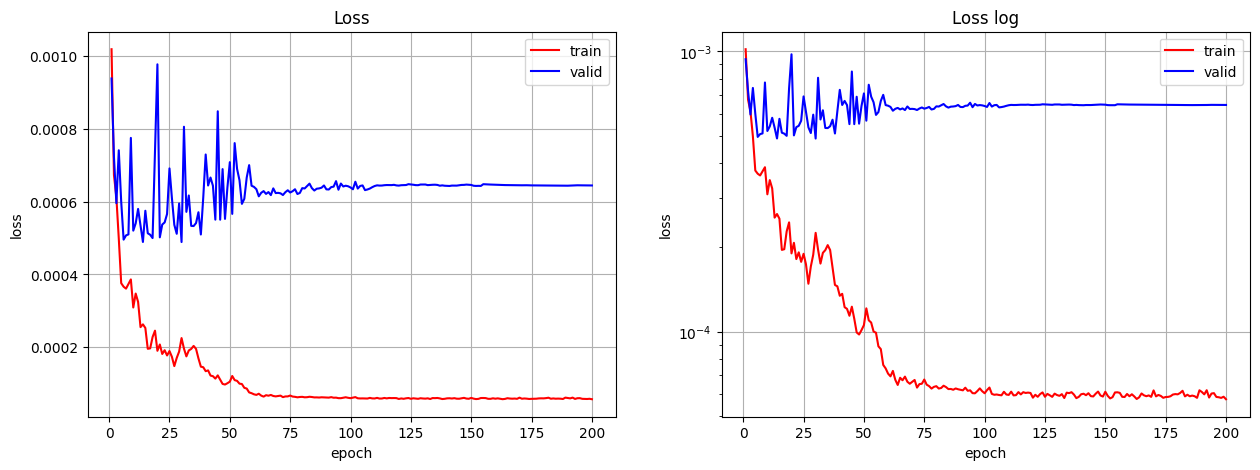

In [78]:
train_and_evaluate_model(best_model, x_train, y_train,
                         x_val, y_val, x_test, y_test)

## Backtesting

In [79]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [80]:
selected_countries = df_countries.columns
days_to_rebalance = dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

In [84]:
total_returns_model_dnn, cum_total_returns_model_dnn = calculate_returns_for_model(
    best_model, x_test, dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


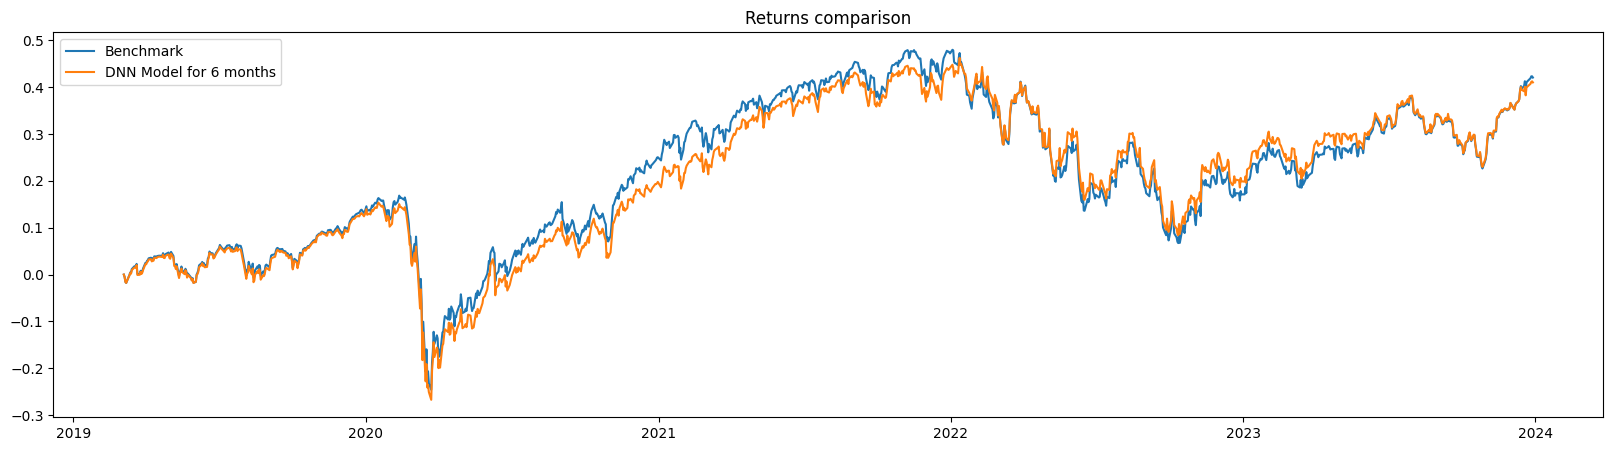

In [85]:
plt.figure(figsize=(20, 5))
plt.plot(cum_benchmark_returns, label='Benchmark')
plt.plot(cum_total_returns_model_dnn,
         label=f'DNN Model for {best_month_no} months')

plt.legend()
plt.title('Returns comparison')
plt.show()

In [86]:
df_results = pd.DataFrame(columns=['Annual Returns', 
                                   'Annual Volatility',
                                   'Sharpe Ratio',
                                   'Sortino Ratio',
                                   'Max Drawdown',
                                   'Max Time Under Water',
                                   'Calmar Ratio',
                                   'Information Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')
calculate_metrics(total_returns_model_dnn, df_results,
                  f'DNN Model for {best_month_no} months', benchmark_returns)
df_results

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
DNN Model for 6 months,0.073975,0.202525,0.365265,0.424311,-0.364945,493.0,0.202703,-0.089714
